# Data Training using TensorFlow

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn.model_selection import train_test_split

In [2]:
X_train = pd.read_csv('./data/train_processed.csv')
X_predict = pd.read_csv('./data/test_processed.csv')

In [3]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,UnknownAge,Baby,Child,Young,FamilySize,Alone,Title,TicketGroup,Survived
0,3,1,0.273456,1,0,0.056604,7,0,0,0,0,1,2,0,2,0.0,0
1,1,0,0.473882,1,0,0.278271,2,1,0,0,0,0,2,0,1,189.0,1
2,3,0,0.323563,0,0,0.061874,7,0,0,0,0,1,1,1,1,0.0,1
3,1,0,0.436302,1,0,0.207289,2,0,0,0,0,0,2,0,1,19.0,1
4,3,1,0.436302,0,0,0.062850,7,0,0,0,0,0,1,1,2,0.0,0


In [4]:
X_predict.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,UnknownAge,Baby,Child,Young,FamilySize,Alone,Title,TicketGroup
0,3,1,0.430039,0,0,0.061126,7,2,0,0,0,0,1,1,2,0.0
1,3,0,0.586622,1,0,0.054652,7,0,0,0,0,0,2,0,1,0.0
2,2,1,0.774521,0,0,0.075635,7,2,0,0,0,0,1,1,2,0.0
3,3,1,0.336089,0,0,0.067632,7,0,0,0,0,1,1,1,2,0.0
4,3,0,0.273456,1,1,0.047967,7,0,0,0,0,1,3,0,1,107.0


Split into 3 sets: train, test and valid

In [5]:
y_train = X_train['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X_train.drop('Survived', axis=1), y_train, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (569, 16) (569,)
Validation set (179, 16) (179,)
Test set (143, 16) (143,)


In [8]:
def reformat(X, y):
    #X = X.reshape((-1, -1)).astype(np.float32)
    y = (np.arange(1) == y[:,None]).astype(np.float32)
    return X, y

In [9]:
X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)

In [10]:
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (569, 16) (569, 1)
Validation set (179, 16) (179, 1)
Test set (143, 16) (143, 1)


In [11]:
def accuracy(predictions, labels):
  correct_pred = tf.equal(tf.round(predictions), labels)
  return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
batch_size = 512
_startLearningRate = 0.05
_learningDecayRate = 0.98
_decaySteps = 1000

graph = tf.Graph()
with graph.as_default():
    
    hidden_units = 10
    is_training = tf.Variable(True, dtype=tf.bool)
#     learning_rate = tf.placeholder(tf.float32)

    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, y_train.shape[1]))
    tf_valid_dataset = tf.cast(tf.constant(X_valid.values), tf.float32)
    #tf_test_dataset = tf.cast(tf.constant(X_test.values), tf.float32)
    
    initializer = tf.contrib.layers.xavier_initializer()
    fc = tf.layers.dense(tf_train_dataset, hidden_units, activation=None, kernel_initializer=initializer)
    fc = tf.layers.batch_normalization(fc, training=is_training)
    fc = tf.nn.relu(fc)
    
    logits = tf.layers.dense(fc, 1, activation=None)    

    #weights = tf.Variable(tf.truncated_normal([X_train.shape[1], y_train.shape[1]]))
#     weights = tf.Variable(tf.truncated_normal([X_train.shape[1], 200]))
#     biases = tf.Variable(tf.zeros([200]))
#     biases = tf.Variable(tf.constant(0.1, shape=[200]))
    
    #weights1 = tf.Variable(tf.truncated_normal([y_train.shape[1], y_train.shape[1]]))
#     weights1 = tf.Variable(tf.truncated_normal([200, y_train.shape[1]]))
#     biases1 = tf.Variable(tf.zeros([y_train.shape[1]]))
#     biases1 = tf.Variable(tf.constant(0.1, shape=[y_train.shape[1]]))

    #logits = tf.matmul(tf_train_dataset, weights) + biases
#     hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)   
#     hidden = tf.nn.dropout(hidden, 0.5)
#     logits = tf.nn.relu(tf.matmul(hidden, weights1) + biases1)

    #test = tf.reduce_mean(tf.nn.softmax(logits))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
#     loss = tf.reduce_mean(tf.nn.softmax(logits))
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(_startLearningRate, global_step, _decaySteps, _learningDecayRate)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    #train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    #test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    train_prediction = tf.nn.sigmoid(logits)
    #valid_prediction = tf.nn.sigmoid()

In [13]:
num_steps = 5001
report_interval = 100
x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []
    
with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    #session = tf_debug.LocalCLIDebugWrapperSession(session)
    #session.add_tensor_filter("has_inf_or_nan", tf_debug.has_inf_or_nan)
    
    print("Initialized")
    for step in range(num_steps):

        offset = (step * batch_size) % (X_train.shape[0] - batch_size)

        batch_data = X_train.values[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]

        feed_dict = { 
            tf_train_dataset: batch_data, 
            tf_train_labels: batch_labels, 
            is_training: True,
            learning_rate: 0.005
        }
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % report_interval == 0):
            x_collect.append(step)
            train_loss_collect.append(l)
            train_acc_collect.append(accuracy(predictions, batch_labels).eval())
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.4f" % accuracy(predictions, batch_labels).eval())
            #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), y_valid))
            #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))
            
        valid_data = X_valid.values
        valid_labels = y_valid
        
        feed_dict = {
            tf_train_dataset: valid_data,
            tf_train_labels: valid_labels,
            is_training: False,
            learning_rate: 0.001
        }
        
        valid_l, valid_predictions = session.run([loss, train_prediction], feed_dict=feed_dict)

        if (step % report_interval == 0):
            valid_loss_collect.append(valid_l)
            valid_acc_collect.append(accuracy(valid_predictions, valid_labels).eval())            
            #print("Valid loss at step %d: %f" % (step, valid_l))
            print("Valid accuracy: %.4f" % accuracy(valid_predictions, valid_labels).eval())
            
        feed_dict = {
            tf_train_dataset: X_predict.values
        }
        
        predict_result = session.run([train_prediction], feed_dict=feed_dict)        
        
    saver.save(session, "./data/model.ckpt")

Initialized
Minibatch loss at step 0: 0.906418
Minibatch accuracy: 0.6035
Valid accuracy: 0.6313
Minibatch loss at step 100: 0.389071
Minibatch accuracy: 0.8379
Valid accuracy: 0.6313
Minibatch loss at step 200: 0.360105
Minibatch accuracy: 0.8496
Valid accuracy: 0.7430
Minibatch loss at step 300: 0.339357
Minibatch accuracy: 0.8789
Valid accuracy: 0.7374
Minibatch loss at step 400: 0.333700
Minibatch accuracy: 0.8730
Valid accuracy: 0.5978
Minibatch loss at step 500: 0.318279
Minibatch accuracy: 0.8672
Valid accuracy: 0.6257
Minibatch loss at step 600: 0.300603
Minibatch accuracy: 0.8809
Valid accuracy: 0.6425
Minibatch loss at step 700: 0.291699
Minibatch accuracy: 0.8828
Valid accuracy: 0.7542
Minibatch loss at step 800: 0.297431
Minibatch accuracy: 0.8867
Valid accuracy: 0.7654
Minibatch loss at step 900: 0.278551
Minibatch accuracy: 0.8984
Valid accuracy: 0.8268
Minibatch loss at step 1000: 0.270693
Minibatch accuracy: 0.9062
Valid accuracy: 0.8156
Minibatch loss at step 1100: 0.2

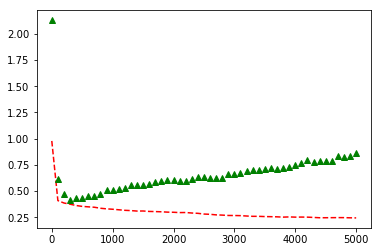

In [57]:
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

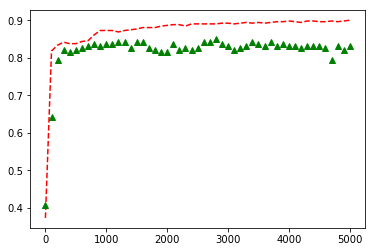

In [58]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [59]:
with tf.Session(graph=graph) as session:

    tf.global_variables_initializer().run()
    saver = tf.train.Saver()        
    saver.restore(session, "./data/model.ckpt")
    
    valid_data = X_valid.values
    valid_labels = y_valid

    feed_dict = {
        tf_train_dataset: valid_data,
        tf_train_labels: valid_labels,
        is_training: False
    }

    valid_l, valid_predictions = session.run([loss, train_prediction], feed_dict=feed_dict)
    print("Valid accuracy: %.4f" % accuracy(valid_predictions, valid_labels).eval())

    feed_dict = {
        tf_train_dataset: X_predict.values
    }

    predict_result = session.run([train_prediction], feed_dict=feed_dict)            

INFO:tensorflow:Restoring parameters from ./data/model.ckpt
Valid accuracy: 0.8324


In [60]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(0.5)

test_predict_result = binarizer.fit_transform(predict_result[0])
test_predict_result = test_predict_result.astype(np.int32)


In [61]:
test = pd.read_csv('./data/test.csv')

In [62]:
r = test['PassengerId'].to_frame()

In [63]:
r['Survived'] = test_predict_result

In [64]:
r.to_csv('./data/output.csv', index=False)

In [65]:
r.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.677033
std,120.810458,0.468170
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,1.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [35]:
import math

_imageSize = X_train.shape[1]
_numLabels = y_train.shape[1]
_trainSubset = 100
_batchSize = 24
_hiddenLayers = [2048, 1]
_numInputs = _imageSize
_startLearningRate = 0.5
_learningDecayRate = 0.98
_decaySteps = 1000
_numSteps = 10001
_regularizationRate = 0.00001
_dropoutKeepRate = 0.5


def accuracy(predictions, labels):
    correct_pred = tf.equal(tf.round(predictions), labels)
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

def validateNumHiddenLayers(numHiddenLayers):
    if numHiddenLayers < 1:
        raise ValueError('Number of hidden layers must be >= 1')

def generateHiddenLayerKey(layerNum):
    return 'h' + str(layerNum)

def generateHiddenLayer(layerNum, previousLayer, weights, biases, training, dropoutKeepRate):
    key = generateHiddenLayerKey(layerNum)
    if training:
        hiddenLayer = tf.nn.relu(tf.matmul(previousLayer, weights[key]) + biases[key])
        hiddenLayer = tf.nn.dropout(hiddenLayer, dropoutKeepRate)
        return hiddenLayer
    else:
        hiddenLayer = tf.nn.relu(tf.matmul(tf.cast(previousLayer, tf.float32), weights[key]) + biases[key])
        return hiddenLayer


def multilayerNetwork(inputs, weights, biases, numHiddenLayers, training, dropoutKeepRate):
    validateNumHiddenLayers(numHiddenLayers)

    hiddenLayer = generateHiddenLayer(1, inputs, weights, biases, training, dropoutKeepRate)

    for layerNum in range(numHiddenLayers+1):
        if layerNum > 1:
            hiddenLayer = generateHiddenLayer(layerNum, hiddenLayer, weights, biases, training, dropoutKeepRate)

    return tf.matmul(hiddenLayer, weights['out']) + biases['out']

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, _imageSize * _imageSize)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(_numLabels) == labels[:, None]).astype(np.float32)
    return dataset, labels

#source:  http://arxiv.org/pdf/1502.01852v1.pdf
def calculateOptimalWeightStdDev(numPreviousLayerParams):
    return math.sqrt(2.0/numPreviousLayerParams)

def generateWeights(hiddenLayers, numInputs, numLabels):
    numHiddenLayers = hiddenLayers.__len__()
    validateNumHiddenLayers(numHiddenLayers)
    weights = {}

    numHiddenFeatures = hiddenLayers[0]
    stddev = calculateOptimalWeightStdDev(numInputs)
    weights[generateHiddenLayerKey(1)] = tf.Variable(tf.truncated_normal([numInputs, numHiddenFeatures], 0, stddev))

    for layerNum in range(numHiddenLayers+1):
        if layerNum > 1:
            previousNumHiddenFeatures = numHiddenFeatures
            numHiddenFeatures = hiddenLayers[layerNum-1]
            stddev = calculateOptimalWeightStdDev(previousNumHiddenFeatures)
            weights[generateHiddenLayerKey(layerNum)] = tf.Variable(tf.truncated_normal([previousNumHiddenFeatures, numHiddenFeatures], 0, stddev))

    stddev = calculateOptimalWeightStdDev(numHiddenFeatures)
    weights['out'] = tf.Variable(tf.truncated_normal([numHiddenFeatures, numLabels], 0, stddev))
    return weights

def generateBiases(hiddenLayers,  numLabels):
    numHiddenLayers = hiddenLayers.__len__()
    validateNumHiddenLayers(numHiddenLayers)
    biases = {}

    numHiddenFeatures = hiddenLayers[0]
    biases[generateHiddenLayerKey(1)] = tf.Variable(tf.zeros([numHiddenFeatures]))

    for layerNum in range(numHiddenLayers+1):
        if layerNum > 1:
            numHiddenFeatures = hiddenLayers[layerNum-1]
            biases[generateHiddenLayerKey(layerNum)] = tf.Variable(tf.zeros([numHiddenFeatures]))

    biases['out'] = tf.Variable(tf.zeros([numLabels]))
    return biases

def generateRegularizers(weights, biases, numHiddenLayers):
    validateNumHiddenLayers(numHiddenLayers)
    regularizers = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['h1'])

    for layerNum in range(numHiddenLayers+1):
        if layerNum > 1:
            regularizers = regularizers + tf.nn.l2_loss(weights['h' + str(layerNum)]) + tf.nn.l2_loss(biases['h' + str(layerNum)])

    regularizers = regularizers + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out'])
    return regularizers

def generateLossCalc(weights, biases, numHiddenLayers, trainingNetwork, trainingLabels, regularizationRate):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=trainingNetwork, labels=trainingLabels))
    regularizers = generateRegularizers(weights, biases, numHiddenLayers)
    loss += regularizationRate * regularizers
    return loss

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, y_train.shape[1]))
    tf_valid_dataset = tf.constant(X_valid.values)
    tf_valid_labels = tf.constant(y_valid)

    numHiddenLayers = _hiddenLayers.__len__()
    weights = generateWeights(_hiddenLayers, _numInputs, _numLabels)
    biases = generateBiases(_hiddenLayers, _numLabels)
    trainingNetwork = multilayerNetwork(tf_train_dataset, weights, biases, numHiddenLayers, True, _dropoutKeepRate)
    loss = generateLossCalc(weights, biases, numHiddenLayers, trainingNetwork, tf_train_labels, _regularizationRate)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(_startLearningRate, global_step, _decaySteps, _learningDecayRate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.nn.softmax(multilayerNetwork(tf_train_dataset, weights, biases, numHiddenLayers, True, _dropoutKeepRate))
    valid_prediction = tf.nn.softmax(multilayerNetwork(tf_valid_dataset, weights, biases, numHiddenLayers, False, _dropoutKeepRate))
    #test_prediction = tf.nn.softmax(multilayerNetwork(tf_test_dataset, weights, biases, numHiddenLayers, False, _dropoutKeepRate))

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(_numSteps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (np.random.randint(1, _trainSubset) * _batchSize) % (X_train.shape[0] - _batchSize)
        # Generate a minibatch.
        batch_data = X_train.values[offset:(offset + _batchSize), :]
        batch_labels = y_train[offset:(offset + _batchSize), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
#         valid_data = X_valid.values
#         valid_labels = y_valid
        
#         feed_dict = {
#             tf_train_dataset: valid_data,
#             tf_train_labels: valid_labels
#         }
        
#         valid_l, valid_predictions = session.run([loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("Minibatch loss at step", step, ":", l)
            print("Minibatch accuracy: %.4f" % accuracy(predictions, batch_labels).eval())
            print("Valid accuracy: %.4f" % accuracy(valid_predictions, valid_labels).eval())            
            #print "Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels)

#     print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0 : 0.0160054
Minibatch accuracy: 0.6250
Valid accuracy: 0.5978
Minibatch loss at step 500 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 1000 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 1500 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 2000 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 2500 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 3000 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 3500 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 4000 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 4500 : nan
Minibatch accuracy: 0.0000
Valid accuracy: 0.5978
Minibatch loss at step 5000 : nan
Minibatch accuracy: 0.0000
Valid accur

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 820 to 766
Data columns (total 16 columns):
Pclass         179 non-null int64
Sex            179 non-null int64
Age            179 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Fare           179 non-null float64
Cabin          179 non-null int64
Embarked       179 non-null int64
UnknownAge     179 non-null int64
Baby           179 non-null int64
Child          179 non-null int64
Young          179 non-null int64
FamilySize     179 non-null int64
Alone          179 non-null int64
Title          179 non-null int64
TicketGroup    179 non-null float64
dtypes: float64(3), int64(13)
memory usage: 23.8 KB
